# import packages and read data

In [1]:
import scipy.io as scio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = scio.loadmat('spamData.mat')
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Aug 16 16:33:53 2021', '__version__': '1.0', '__globals__': [], 'Xtrain': array([[  0.   ,   0.   ,   0.   , ...,   4.5  ,  34.   , 108.   ],
       [  0.   ,   0.   ,   0.71 , ...,   1.974,  34.   , 229.   ],
       [  0.   ,   0.   ,   0.   , ...,   1.   ,   1.   ,   5.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ...,   1.884,   9.   ,  98.   ],
       [  0.   ,   0.   ,   0.7  , ...,   1.333,   4.   ,  16.   ],
       [  0.   ,   0.   ,   0.   , ...,   1.   ,   1.   ,   4.   ]]), 'Xtest': array([[1.500e-01, 0.000e+00, 6.300e-01, ..., 1.111e+00, 7.000e+00,
        3.890e+02],
       [0.000e+00, 0.000e+00, 7.000e-01, ..., 1.820e+00, 1.800e+01,
        3.040e+02],
       [5.800e-01, 0.000e+00, 1.900e-01, ..., 3.015e+00, 2.100e+01,
        1.900e+02],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.142e+00, 3.000e+00,
        4.000e+01],
       [0.000e+00, 0.000e+00, 3.100e-01, ..., 1.515e+00, 1

In [3]:
X_train = pd.DataFrame(data['Xtrain'])
X_test = pd.DataFrame(data['Xtest'])
y_train = pd.DataFrame(data['ytrain'])
y_test = pd.DataFrame(data['ytest'])

# Data Processing:
## Use log-transform: transform each feature using log(Xij + 0.1) (assume natural log)

In [4]:
X_train_log = np.log(X_train + 0.1)
X_test_log = np.log(X_test + 0.1)

## For the log-transformed data, fit a logistic regression model with l2 regularization, value λ as input , fit the logistic regression model on the training data and compute its error rate on the test data.

In [5]:
class  Logistic_Regression_Classifier():

    '''      
        X_train(pd.DataFrame) : features of train data, N*D
        y_train(pd.DataFrame) : label of train data, N*1  
        X_test(pd.DataFrame) : features of test data
        y_test(pd.DataFrame) : label of test data
        lamda(int) : hyperparameter of l2 regression
        K(int) : iteration number of Logistic Regression Classifier
    '''
    def __init__(self, X_train, y_train, X_test, y_test, lamda, K): 
        '''
        X_train = N * D
        y_train = N * 1
        '''
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.lamda = lamda
        self.K = K
    
    '''
        x(np.ndarray) : input x ,return the sigmoid of x
    '''
    #calculate the sigmoid(x)
    def sigmoid(self, x):
        return 1. / (1+np.exp(-x))
    
    '''      
        W(np.ndarray) : weight of Logistic Regression, D+1 * 1
        X(np.ndarray) : train data, N * D+1  
        X_t(np.ndarray) : transposition of X, D+1 * N
        y(np.ndarray) : label of train data, N * 1
    '''
    #Calculate the gradient and hessian matrix with l2 regression
    def gradient_and_hessian_l2_Regression(self, W, X, X_t, y):

        W_t = np.transpose(W)
        #miu = N * 1
        miu = self.sigmoid(np.dot(X, W))
        g = np.dot(X_t, (miu-y))
        W_NoBias = W.copy()
        W_NoBias[0] = 0
        #g_l2reg = D+1 * 1
        g_l2reg = g + self.lamda*W_NoBias
        
        miu_diag = np.array([m*(1-m) for m in miu])
        S = np.diag(miu_diag.flatten())
        H = np.dot(np.dot(X_t, S), X)
        H_NoBias = np.eye(X.shape[1])
        H_NoBias[0,0]=0
        #H_l2reg = D+1 * D+1
        H_l2reg = H + self.lamda*H_NoBias
    
        return g_l2reg,H_l2reg
    
    '''      
        K(int) : iteration number of Logistic Regression Classifier
    '''
    # Caculate the weight after iteration of K times
    def Train_W(self, K):
        X_train = self.X_train.copy()
        X_train['bias'] = 1
        # X = N * D+1
        X = X_train.values
        X_t = np.transpose(X)
        y = self.y_train.values
        W = np.zeros((X_train.shape[1],1))
        miu = self.sigmoid(np.dot(X, W))
        for k in range(0, K):
            g_l2reg,H_l2reg = self.gradient_and_hessian_l2_Regression(W, X, X_t, y)
            d = -np.dot(np.linalg.inv(H_l2reg) , g_l2reg)
            W = W + d
            
        return W
    
    '''      
        X_to_predict(pd.DataFrame) : Data to predict
    '''
    #input features ,predict the lable.
    def predict_label(self, X_to_predict, W):
          
        X_Bias = X_to_predict.copy()
        X_Bias['bias'] = 1
        X = X_Bias.values
        log_odds = np.dot(X,W)
        predict = [1 if log>0 else 0 for log in log_odds]
            
        return predict
        
     
    '''      
        pred(list) : Predict label of data
        true(np.ndarray) : True label of data
    '''
    #calculate the error rate(%) of the predict label and true label
    def calculate_error(self, pred, true):
        return (pred^true).sum() / len(pred) * 100
    
    #return the train error rate and test error rate
    def run(self):
        
        # get w based on feature values
        Trained_W = self.Train_W(self.K)
        # get predictions
        train_predict = self.predict_label(self.X_train, Trained_W)
        test_predict = self.predict_label(self.X_test, Trained_W)
        # score and return results
        return self.calculate_error(train_predict, self.y_train[0].values), \
               self.calculate_error(test_predict, self.y_test[0].values)

## Let λ=1 ， try to find the K can make W convergence

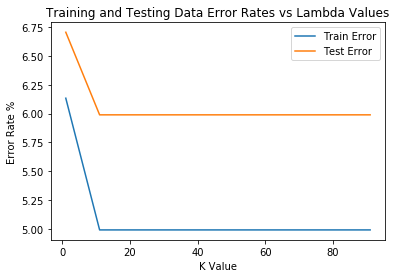

In [6]:
list_of_K = list(np.arange(1, 100, 10))
train_error_list = []
test_error_list = []

# loop over lambda values
for K in list_of_K:
    lamda = 1
    lgr = Logistic_Regression_Classifier(X_train_log, y_train, X_test_log, y_test, lamda, K)
    train_error, test_error = lgr.run()
    train_error_list.append(train_error)
    test_error_list.append(test_error)
    
# plot chart
plt.plot(list_of_K, train_error_list, label='Train Error')
plt.plot(list_of_K, test_error_list, label='Test Error')
plt.ylabel('Error Rate %')
plt.xlabel('K Value')
plt.title('Training and Testing Data Error Rates vs Lambda Values')
plt.legend()
plt.show()

## Make sure it converges for every λ, we can make K=30

## Q3(a)
## For each regularization parameter value λ = {1, 2, · · · , 9, 10, 15, 20, · · · , 95, 100}

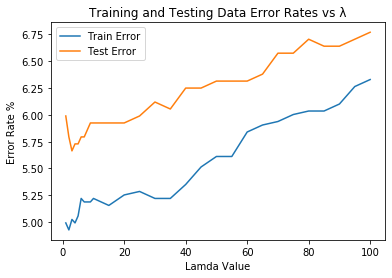

In [7]:
# initialise empty list for storage
lamdas = list(np.arange(1, 10, 1))
lamdas.extend(list(np.arange(10, 105, 5)))
K = 30
train_error_list = []
test_error_list = []

# loop over lamda values
for lamda in lamdas:
    lgr = Logistic_Regression_Classifier(X_train_log, y_train, X_test_log, y_test, lamda, K)
    train_error, test_error = lgr.run()
    train_error_list.append(train_error)
    test_error_list.append(test_error)
    
# plot chart
plt.plot(lamdas, train_error_list, label='Train Error')
plt.plot(lamdas, test_error_list, label='Test Error')
plt.ylabel('Error Rate %')
plt.xlabel('Lamda Value')
plt.title('Training and Testing Data Error Rates vs λ')
plt.legend()
plt.show()

## Q3(b)
## What do you observe about the training and test errors as λ change?
In summary, the errors for both train and test increase as λ increases. <br>
For every value of λ, the test error rates are always higher than the train error rates. The best λ for train data is about 2, and the train error rate is about 4.9%. The best λ for test data is about 4, and the train error rate is about 5.7%.

## Q3(c)
## Training and testing error rates for λ = 1, 10 and 100.

In [8]:
for lamda in [1, 10, 100]:
    index = lamdas.index(lamda)
    print('When λ = %d :train error rate is %f%% , test error rate is %f%%' %(lamda, train_error_list[index], test_error_list[index]))

When λ = 1 :train error rate is 4.991843% , test error rate is 5.989583%
When λ = 10 :train error rate is 5.220228% , test error rate is 5.924479%
When λ = 100 :train error rate is 6.329527% , test error rate is 6.770833%
